# Tutorial on how to use the ripple type classifier


Ripple type classifier can predict the underlying ripple-laminar profile based on the LFP waveform (i.e. either LM$^{sink}$, intermediate or Rad$^{sink}$ ripples).

To use it, you only need the local field potential (LFP) signal from the pyramidal layer of CA1.

In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['xtick.labelsize']=15
matplotlib.rcParams['ytick.labelsize']=15

# Suppress the specific warning due to sklearn (model was saved in previous sklean version)
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

# import custom libraries
from ripple_classifier import utils, ripple_classifier

# Load Data

This repository contains all ripples detected during a sleep/rest session in one mouse, recorded with a silicon probe along the CA1 somatodendritic axis.

In [2]:
dataDir = './data/'

# Load Channel information
layers = np.load(dataDir+'channels.info',allow_pickle=True)

# Load ripple-triggered LFP data
rip_LFPs = np.load(dataDir+'lfps_data.ripples',allow_pickle=True)

# Triggered-average time axis
winL_ms = 200
talen = int(2 * (winL_ms /utils.DTT))
taxis = np.arange(-winL_ms,winL_ms,utils.DTT)

In [3]:
print(rip_LFPs.shape)
print('(# ripples, # channels, # time samples)')

(4429, 31, 500)
(# ripples, # channels, # time samples)


## Plotting the average CSD Profile

Plotting the grand average current source density (CSD) laminar profile.

CSD was computed as (Mitzdorf, 1985):

$$CSD[t]_n=−(LFP[t]_{n−1}−2∗LFP[t]_n+LFP [t]_{n+1})$$

where $LFP[t]_{n−1}$, $LFP[t]_n$ and $LFP[t]_{n+1}$ are the LFP signals at time t recorded from neighboring electrodes (20 $\mu m$ apart).

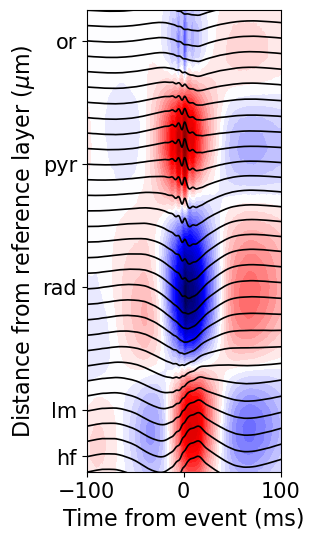

In [4]:
lfp_mu = rip_LFPs.mean(axis=0)
csd_mu = utils.runCSD(lfp_mu)

f,ax = plt.subplots(figsize=(2.5,6))
utils.plotCSD(csd_mu,lfp_mu,taxis,ax=ax,layers=layers,lw=1.2)
ax.set_xlim([-100,100]);ax.set_xticks([-100,0,100]);
plt.show();

## Load Ripple-waveform classifier 

Linear discriminant analysis (LDA) trained to predict ripple laminar profile (i.e. LM$^{sink}$, intermediate or Rad$^{sink}$ ripples) using the LFP waveform from the pyramidal layer of CA1.

In [5]:
ripple_classifier.model_report()

#### REPORT ON TRAINED MODEL ####
Dataset used to train the LDA model contained 114460 ripples from 5 mice. 


In [6]:
# Extract the CA1 pyramidal LFP and plot the mean ripple waveform
pyrchi = layers['pyr']
pyr_lfp  = rip_LFPs[:,pyrchi]

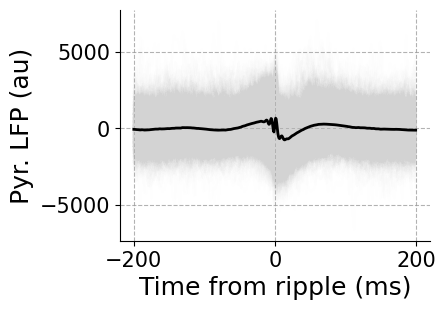

In [7]:
plt.figure(figsize=(4,3))
plt.plot(taxis,pyr_lfp.T[:,:1000],color='lightgray',alpha=0.01);
plt.plot(taxis,pyr_lfp.mean(0),color='k',lw=2)
utils.label_plot('Time from ripple (ms)', 'Pyr. LFP (au)')
utils.AdjustBoxPlot();

## Preparing LFP waveforms for model input and classifying ripple types

In [8]:
# Input LFP-formatted data into model for pre-processing and estimation
lfp_input,taxis_classifier_ms = ripple_classifier.format_lfp_inputs_to_classifier(pyr_lfp,taxis)

In [14]:
print(lfp_input.shape)
print('(# ripples, # time samples)')

(4429, 250)
(# ripples, # time samples)


In [9]:
# Get Index of Each predicted Class
lm_sink,intermediate,rad_sink = ripple_classifier.predict_ripple_types(lfp_input)

### Plot the mean (and 95% CI) waveform of each predicted ripple type.

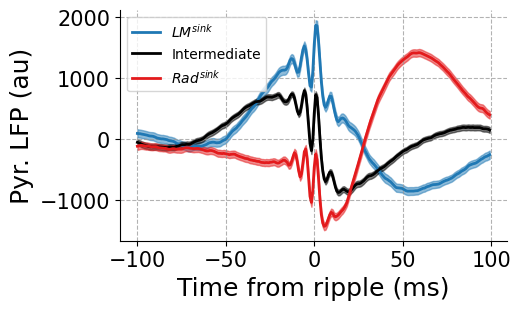

In [12]:
colors = [utils.col_paired[1],'k',utils.col_paired[5]]
labels = ['$LM^{sink}$','Intermediate','$Rad^{sink}$']

plt.figure(figsize=(5,3))
for lbl,col,idx in zip(labels,colors,[lm_sink,intermediate,rad_sink]):
    utils.plt_Mean_CI_Area(taxis_classifier_ms,lfp_input[idx],color=col,\
                           label=lbl, method_ci='bootstraps')
    
utils.label_plot('Time from ripple (ms)','Pyr. LFP (au)',legend=True)
utils.AdjustBoxPlot()

## Cross-validate model predictions by plotting the CSDs of each predicted riple type

Now we cross-validate the model predictions, which are based solely on LFP waveforms, against the CSD data to verify that the current sink is located in the expected layer.

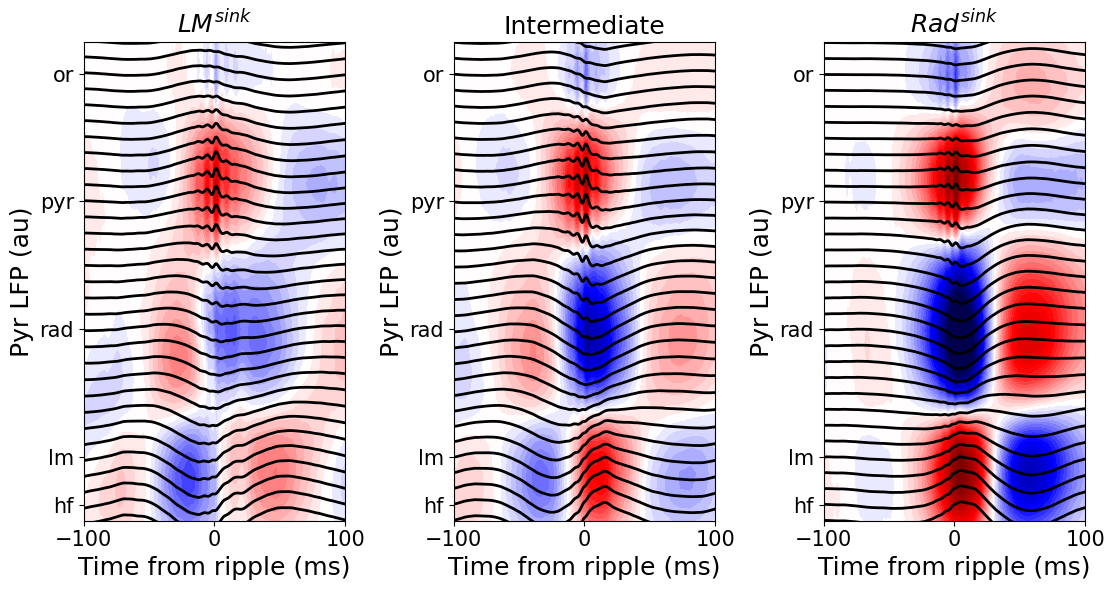

In [11]:
levels =  150*np.linspace(-1,1,50)

f,axes = plt.subplots(1,3,figsize=(2.5*4.5,6))
for ax,lbl,idx in zip(axes,labels,[lm_sink,intermediate,rad_sink]):
    lfps_mean_trig = rip_LFPs[idx].copy().mean(axis=0)
    csd_mean_trig = utils.runCSD(lfps_mean_trig)
    utils.plotCSD(csd_mean_trig,lfps_mean_trig,taxis,\
                     ax=ax,layers=layers,lw=2,levels_=levels)
    ax.set_xlim([-100,100]);ax.set_xticks([-100,0,100]);
    utils.label_plot('Time from ripple (ms)','Pyr LFP (au)',lbl,ax=ax)
f.tight_layout()